In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = Colorado
state_ab = "co"

## Data
1. Download all the data in directory "co_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2021/2021_Approved_Congressional_Plan_w_Final_Adjustments.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2021/2021_Approved_Senate_Plan_w_Final_Adjustments.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2021/2021_Approved_House_Plan_w_Final_Adjustments.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/co_pl2020_cnty.shp".format(data_folder, state_ab)

In [5]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [11]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [12]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [13]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [14]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [15]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [16]:
maup.doctor(population_df)

100%|███████████████████████████████████| 140345/140345 [01:19<00:00, 1765.93it/s]


True

In [17]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [18]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [19]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [20]:
maup.doctor(county_df)

100%|████████████████████████████████████████████| 64/64 [00:00<00:00, 234.95it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [21]:
vest20 = gpd.read_file(vest20_data)

In [22]:
vest20.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'PRECINCT', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PRECBLA', 'G20PREUWES',
       'G20PREOOTH', 'G20USSDHIC', 'G20USSRGAR', 'G20USSLDOA', 'G20USSODOY',
       'G20USSOEVA', 'G20USSOWRI', 'geometry'],
      dtype='object')

In [23]:
start_col = 5
vest_base_data = vest20
year = '20'

In [24]:
# vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)
vest_base = add_vest_base(vest_base_data, start_col, year)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 14936/14936 [00:06<00:00, 2325.06it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify: 5451it [30:48,  2.95it/s]                                       
Gaps to fill: 100%|█████████████████████████████| 595/595 [03:58<00:00,  2.50it/s]


In [25]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:1700])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [26]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 3268/3268 [00:00<00:00, 3435.57it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|███████████████████████████████████████| 3215/3215 [00:03<00:00, 1047.92it/s]


In [27]:
maup.doctor(vest_base)

100%|███████████████████████████████████████| 3215/3215 [00:02<00:00, 1092.35it/s]


True

## If it is true for maup doctor, we will use it as the base vest data.

In [28]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|████████████████████████████████████████| 3215/3215 [00:10<00:00, 311.06it/s]


In [29]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [30]:
election_df = gpd.GeoDataFrame(vest_base)

In [31]:
election_df.columns

Index(['COUNTYFP', 'NAME', 'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT', 'STATEFP',
       'USS20D', 'USS20O', 'USS20R', 'VTDST', 'geometry', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI',
       'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [32]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [33]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [34]:
vest18.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'PRECINCT', 'G18GOVDPOL',
       'G18GOVRSTA', 'G18GOVLHEL', 'G18GOVOHAM', 'G18ATGDWEI', 'G18ATGRBRA',
       'G18ATGLROB', 'G18SOSDGRI', 'G18SOSRWIL', 'G18SOSCCAM', 'G18SOSOHUB',
       'G18TREDYOU', 'G18TRERWAT', 'G18TRECKIL', 'G18RGTDSMI', 'G18RGTRMON',
       'G18RGTLTRE', 'G18RGTOOTW', 'geometry'],
      dtype='object')

In [35]:
vest16.columns

Index(['STATEFP', 'COUNTYFP', 'VTDST', 'NAME', 'PRECINCT', 'G16PREDCLI',
       'G16PRERTRU', 'G16PRELJOH', 'G16PREGSTE', 'G16PREUMCM', 'G16PREOOTH',
       'G16USSDBEN', 'G16USSRGLE', 'G16USSLTAN', 'G16USSGMEN', 'G16USSOOTH',
       'G16RGTDMAD', 'G16RGTRGAN', 'geometry'],
      dtype='object')

In [36]:
# check the result here
start_col = 5
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|███████████████████████████████████████| 3136/3136 [00:02<00:00, 1061.04it/s]


There are 1543 overlaps.
There are 3318 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 13882/13882 [00:04<00:00, 3403.16it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify: 5025it [26:57,  3.11it/s]                                       
100%|████████████████████████████████████████| 3215/3215 [00:10<00:00, 304.76it/s]


population agrees


In [37]:
start_col = 5
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|████████████████████████████████████████| 3010/3010 [00:03<00:00, 983.65it/s]


There are 2130 overlaps.
There are 4793 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 17287/17287 [00:05<00:00, 3211.00it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Assigning order 4 pieces...
Filling gaps...


Gaps to simplify: 6522it [37:35,  2.89it/s]                                       
100%|████████████████████████████████████████| 3215/3215 [00:10<00:00, 296.55it/s]


population agrees


##  Add the district data

In [38]:
cd = gpd.read_file(cd_data)
cd = cd.to_crs(cd.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [39]:
cd.head()

,OBJECTID,District,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,1,1,2.495876,7.814496e+05,4.336640e+09,"POLYGON ((528332.428 4417476.024, 529133.296 4..."
1,2,2,11.320395,3.521568e+06,3.218254e+11,"POLYGON ((333593.491 4541018.361, 333969.996 4..."
2,3,3,23.731473,7.604425e+06,1.396837e+12,"POLYGON ((300926.458 4541796.917, 301046.383 4..."
3,4,4,19.406221,6.234628e+06,9.005584e+11,"POLYGON ((701991.732 4541803.867, 703352.268 4..."
4,5,5,3.028264,9.616973e+05,4.109716e+10,"POLYGON ((507585.644 4331188.895, 507588.758 4..."


In [40]:
election_df = add_district(cd, "CD", election_df, "District")

100%|███████████████████████████████████████████████| 8/8 [00:00<00:00, 43.34it/s]


There are 5 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|████████████████████████████████████████████| 13/13 [00:00<00:00, 446.28it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 100%|█████████████████████████████| 5/5 [00:01<00:00,  4.38it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|███████████████████████████████████████████████| 8/8 [00:00<00:00, 13.29it/s]


In [41]:
send.head()

,OBJECTID,District,Shape_Leng,Shape_Area,geometry
0,1,1,3.080656e+06,3.564080e+11,"MULTIPOLYGON (((520695.679 4470538.612, 520702..."
1,2,2,5.278787e+05,3.252466e+09,"POLYGON ((517794.282 4379619.639, 517920.982 4..."
2,3,3,1.099216e+06,6.685520e+10,"POLYGON ((580761.859 4264189.549, 580853.267 4..."
3,4,4,2.995556e+06,2.069199e+11,"POLYGON ((485595.754 4386559.665, 485673.257 4..."
4,5,5,3.619013e+06,2.167483e+11,"POLYGON ((318568.190 4388183.554, 318525.846 4..."


In [42]:
election_df = add_district(send, "SEND", election_df, "District")

100%|████████████████████████████████████████████| 35/35 [00:00<00:00, 182.54it/s]


There are 11 overlaps.
There are 9 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|████████████████████████████████████████████| 57/57 [00:00<00:00, 990.27it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 100%|███████████████████████████| 11/11 [00:00<00:00, 12.61it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 35/35 [00:00<00:00, 43.39it/s]


In [43]:
hdist.head()

,OBJECTID,District,Shape_Leng,Shape_Area,geometry
0,1,1,221814.501000,4.541396e+08,"POLYGON ((497081.946 4394710.176, 497185.250 4..."
1,2,2,93555.504961,3.488605e+08,"POLYGON ((503411.388 4397692.318, 503411.663 4..."
2,3,3,191869.674113,5.994867e+08,"POLYGON ((498653.936 4392095.394, 498850.922 4..."
3,4,4,101223.744383,3.231791e+08,"POLYGON ((497849.416 4404573.526, 497850.181 4..."
4,5,5,135698.713049,4.272490e+08,"POLYGON ((502676.284 4405069.023, 502676.397 4..."


In [44]:
election_df = add_district(hdist, "HDIST", election_df, "District")

100%|████████████████████████████████████████████| 65/65 [00:00<00:00, 242.90it/s]


There are 12 overlaps.
There are 26 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████████| 105/105 [00:00<00:00, 1110.52it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


Gaps to simplify: 100%|███████████████████████████| 21/21 [00:02<00:00,  8.32it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|█████████████████████████████████████████████| 65/65 [00:01<00:00, 64.77it/s]


In [45]:
maup.doctor(election_df)

100%|████████████████████████████████████████| 3215/3215 [00:03<00:00, 962.25it/s]


True

### Put the base precinct year after the precinct information column

In [51]:
base_columns = {
    'STATEFP':'STATEFP'+year,
    'COUNTYFP':'COUNTYFP'+year,
    'PRECINCT':'PRECINCT'+year,
    'NAME':'NAME'+year,
    'VTDST':'VTDST'+year
}
election_df.rename(columns=base_columns, inplace = True)

In [52]:
# reorder the columns

fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'PRECINCT'+year,
    'VTDST'+year,
    'NAME'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [54]:
import os

# store the result in directory "co"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

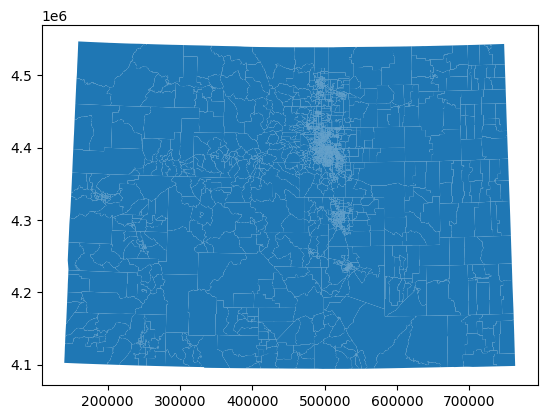

In [55]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()